# Averaged Plot

Make a plot with a single, depth-averaged curve

In [55]:
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt

# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM

import glob
import os

import matplotlib.ticker as ticker

In [56]:
# smoothing window, mm -- i'm not actually doing anything with this here.. 
window = 10

# path to data: AFTER Button edits!!
path_to_data = '../../data/processed_data_after-button-edits/dic1/' 
metadata_file = 'metadata.csv'

In [57]:
#%% Read in metadata and import data

meta = pd.read_csv(path_to_data+metadata_file)

# import each script as an ECM class item
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index,row in meta.iterrows():
    
    core = row['core']
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']
    
    if core == 'dic1':
        
        print("Reading "+core+", section "+str(section)+'-'+face+'-'+ACorDC)
    
        data_item = ECM(core,section,face,ACorDC,path_to_data)
        data_item.rem_ends(10)
        data_item.smooth(window)
        #data_item.norm_all()
        #data_item.norm_outside()
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)

sec = set(sections)

Reading dic1, section 142-t-AC
Reading dic1, section 142-t-DC
Reading dic1, section 150-t-AC
Reading dic1, section 150-t-DC
Reading dic1, section 151-t-AC
Reading dic1, section 151-t-DC
Reading dic1, section 152-t-AC
Reading dic1, section 152-t-DC
Reading dic1, section 153-t-AC
Reading dic1, section 153-t-DC
Reading dic1, section 154-t-AC
Reading dic1, section 154-t-DC
Reading dic1, section 155-t-AC
Reading dic1, section 155-t-DC
Reading dic1, section 156-t-AC
Reading dic1, section 156-t-DC
Reading dic1, section 157-t-AC
Reading dic1, section 157-t-DC
Reading dic1, section 158-t-AC
Reading dic1, section 158-t-DC
Reading dic1, section 159-t-AC
Reading dic1, section 159-t-DC
Reading dic1, section 160-t-AC
Reading dic1, section 160-t-DC
Reading dic1, section 161-t-AC
Reading dic1, section 161-t-DC
Reading dic1, section 162-t-AC
Reading dic1, section 162-t-DC
Reading dic1, section 163-t-AC
Reading dic1, section 163-t-DC
Reading dic1, section 164-t-AC
Reading dic1, section 164-t-DC
Reading 

In [58]:
# combine all records into a single large array


AC_first = True
DC_first = True

for d in data:
    if d.ACorDC == 'AC':
        if AC_first:
            AC_depth = d.depth_s
            AC_meas = d.meas_s
            AC_button = d.button_s
            AC_first = False
        else:
            AC_depth = np.concatenate((AC_depth,d.depth_s))
            AC_meas = np.concatenate((AC_meas,d.meas_s))
            AC_button = np.concatenate((AC_button,d.button_s))
    else:
        if DC_first:
            DC_depth = d.depth_s
            DC_meas = d.meas_s
            DC_button = d.button_s
            DC_first = False
        else:
            DC_depth = np.concatenate((DC_depth,d.depth_s))
            DC_meas = np.concatenate((DC_meas,d.meas_s))
            DC_button = np.concatenate((DC_button,d.button_s))

# sort by depth
AC_sort = np.argsort(AC_depth)
AC_depth = AC_depth[AC_sort]
AC_meas = AC_meas[AC_sort]
AC_button = AC_button[AC_sort]

DC_sort = np.argsort(DC_depth)
DC_depth = DC_depth[DC_sort]
DC_meas = DC_meas[DC_sort]
DC_button = DC_button[DC_sort]

In [59]:
def get_average(depth, meas, button):

    # filter out any bad data (button = 1)
    depth = depth[button==0]
    meas = meas[button==0]

    # set min depth to min (in m rounded to nearest cm)
    min_depth = np.round(np.min(depth),2)
    max_depth = np.round(np.max(depth),2)

    # make an evenly spaced depth array (1 cm spacing)
    depth_all = np.arange(min_depth+0.005, max_depth+0.005, 0.01)

    n = len(depth)
    meas_all = np.full(depth_all.shape, np.nan, dtype=float)
    l = 0
    r = 0
    for i, center in enumerate(depth_all):
        low = center - 0.005
        high = center + 0.005

        # advance left pointer to first index >= low
        while l < n and depth[l] < low:
            l += 1
        # ensure r is at least l
        if r < l:
            r = l
        # advance right pointer to first index >= high
        while r < n and depth[r] < high:
            r += 1

        if l < r:
            meas_all[i] = meas[l:r].mean()

    return depth_all, meas_all


In [60]:
# compute average AC and DC measurements
AC_depth_all, AC_meas_all = get_average(AC_depth, AC_meas, AC_button)
DC_depth_all, DC_meas_all = get_average(DC_depth, DC_meas, DC_button)   

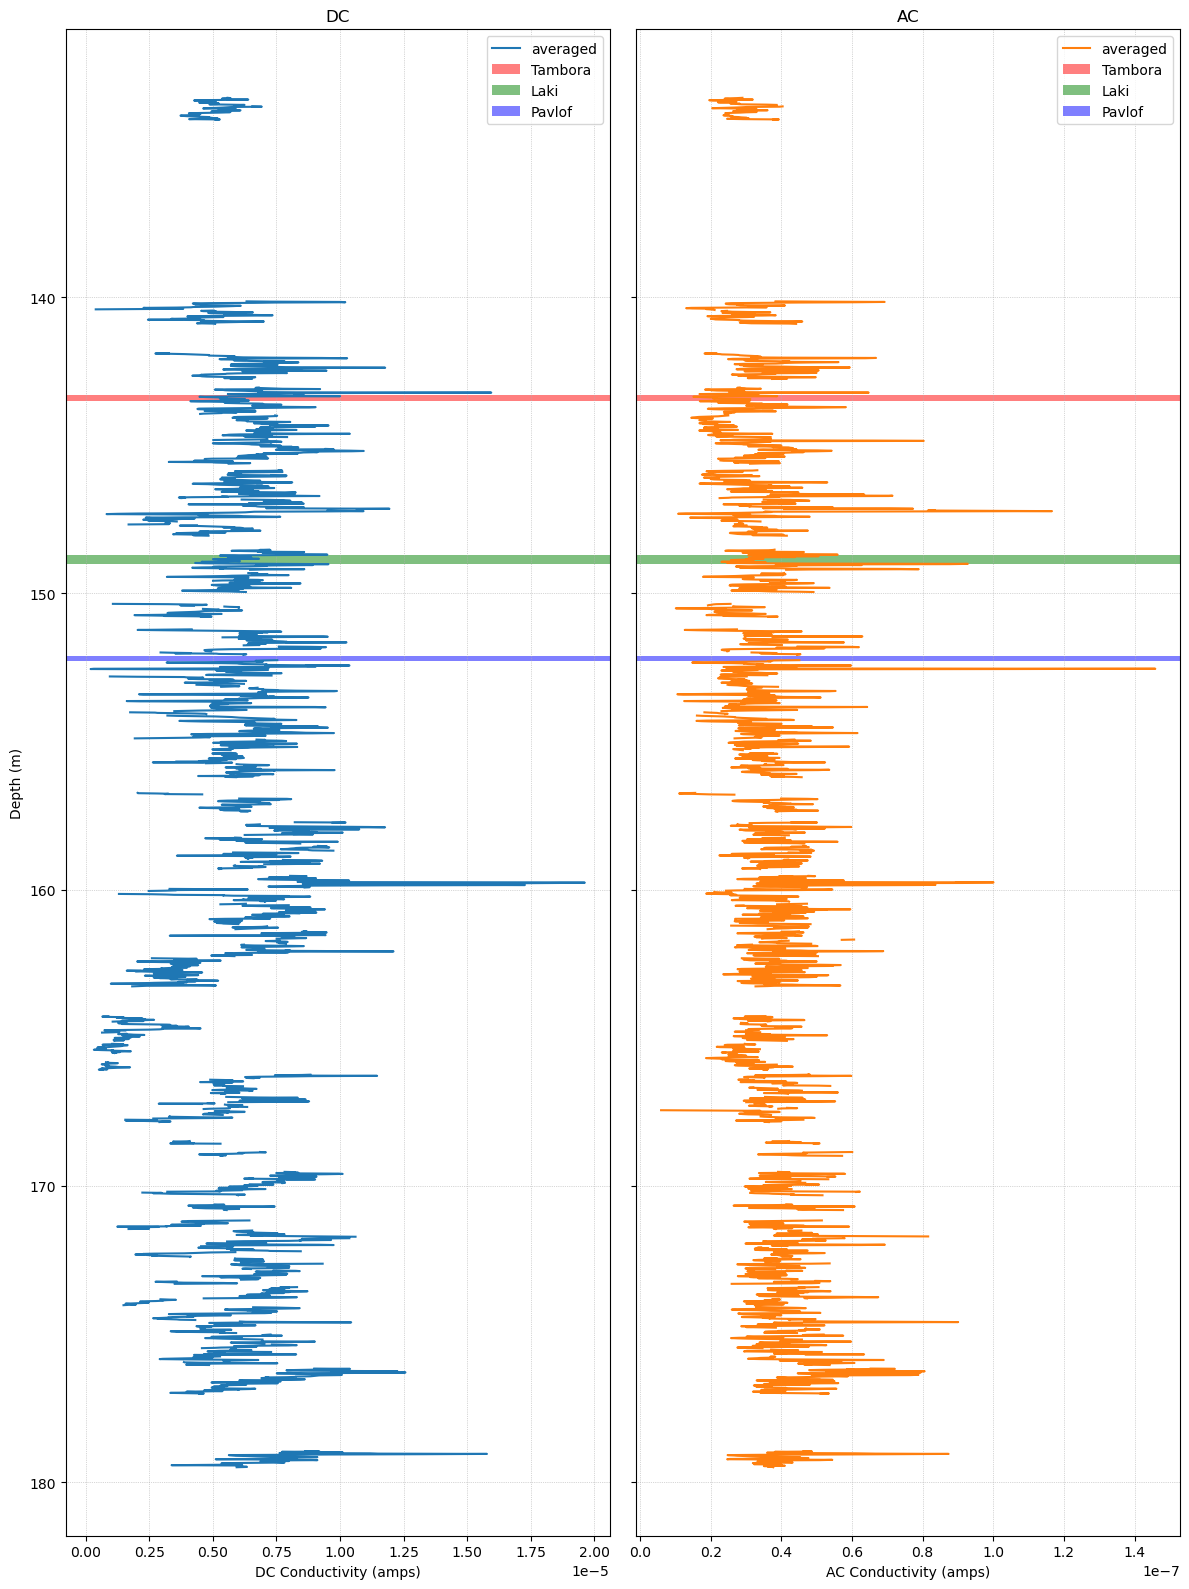

In [61]:
# Plot DC (left) and AC (right) averaged profiles with depth increasing downward

fig, axes = plt.subplots(1, 2, figsize=(12, 16), sharey=True)

# Left: DC
#axes[0].plot(DC_meas,DC_depth, '.', color='C0', markersize=1, alpha = 0.03, label='raw data') # toggle this off to only see average
axes[0].plot(DC_meas_all, DC_depth_all, color='C0', label='averaged')
axes[0].set_title('DC')
axes[0].set_xlabel('DC Conductivity (amps)')
axes[0].grid(True, which='both', ls=':', lw=0.5)

# Right: AC
#axes[1].plot( AC_meas, AC_depth, '.', color='C1', markersize=1, alpha = 0.03, label='raw data') # toggle this off to only see average
axes[1].plot(AC_meas_all, AC_depth_all, color='C1', label='averaged')
axes[1].set_title('AC')
axes[1].set_xlabel('AC Conductivity (amps)')
axes[1].grid(True, which='both', ls=':', lw=0.5)

# Shared y-axis settings: depth increasing downward
axes[0].set_ylabel('Depth (m)')
axes[0].invert_yaxis()

# add volcanic erruptions
for a in axes:
    a.axhspan(143.3, 143.5, color="r", alpha=0.5, ec='none', zorder = 0, label = 'Tambora')
    a.axhspan(148.7, 149, color="g", alpha=0.5, ec='none', zorder = 0, label = 'Laki')
    a.axhspan(152.1, 152.3, color="b", alpha=0.5, ec='none', zorder = 0, label = 'Pavlof')
    a.legend()

plt.tight_layout()
plt.show()